In [1]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")
import numpy as np

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

import matplotlib.pyplot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 
                      'bonus', 'restricted_stock_deferred', 'deferred_income', 
                      'total_stock_value', 'expenses', 'exercised_stock_options', 
                      'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'from_poi_to_this_person',
                  'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
poi_label =['poi']
features_list = poi_label + financial_features + email_features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


C:\Users\admin\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Dataset Exploration
## Find total number of people
print ("Number of people in dataset: %i" % len(data_dict))

## Find number / percentage of persons of interest
poi_count = 0
for name in data_dict:
    if data_dict[name]['poi'] == 1:
        poi_count += 1
print ("Number of Persons of Interest ('POI'): %i " % poi_count)
print ("%% of Persons who are POIs: %f%%" % ((float(poi_count)/len(data_dict))*100))

## Find number of features in data_dict
for name, data in data_dict.iteritems():
    print ("Number of Features in Dataset: %i " % len(data))
    break

## Find the number of missing values for each feature
NaN_count = {}
for name, data in data_dict.iteritems():
    for key, value in data.iteritems():
        if value == 'NaN':
            if key in NaN_count:
                NaN_count[key] += 1
            else:
                NaN_count[key] = 1

## Sort the list of missing values descending, and print out the top 5
NaN_count = sorted(NaN_count.items(), key=lambda x:x[1], reverse=True)
print ("\nTop 5 features with missing values: ")
for i, data in enumerate(NaN_count):
    if i < 5:
        print "%s: %i" % (data[0], data[1])

Number of people in dataset: 146
Number of Persons of Interest ('POI'): 18 
% of Persons who are POIs: 12.328767%
Number of Features in Dataset: 21 

Top 5 features with missing values: 
loan_advances: 142
director_fees: 129
restricted_stock_deferred: 128
deferral_payments: 107
deferred_income: 97


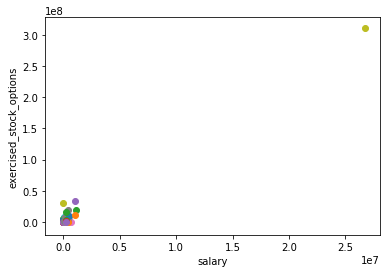

26704229 TOTAL
Removing outlier: TOTAL


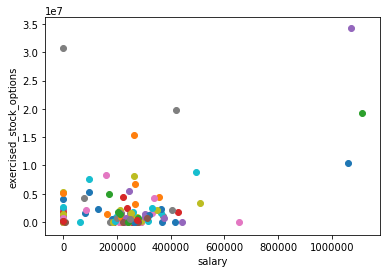


Top 5 persons with missing features:
LOCKHART EUGENE E: 20
WHALEY DAVID A: 18
WROBEL BRUCE: 18
THE TRAVEL AGENCY IN THE PARK: 18
GRAMM WENDY L: 18

Removing outlier: LOCKHART EUGENE E
Removing outlier: THE TRAVEL AGENCY IN THE PARK


{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

In [3]:
### Task 2: Remove outliers
# Identify Outliers
## Create a function to identify outliers on a plot
def outlier_id(data_dict, feature1, feature2):
    features = [feature1, feature2]
    data = featureFormat(data_dict, features)

    for point in data:
        x = point[0]
        y = point[1]
        matplotlib.pyplot.scatter( x, y )

    matplotlib.pyplot.xlabel(feature1)
    matplotlib.pyplot.ylabel(feature2)
    matplotlib.pyplot.show()

outlier_id(data_dict, "salary", "exercised_stock_options")

## Identify the person with the min and max value for each feature.
## Create a dictionary of dictionaries containing feature name, min/max values, and min/max names
min_max_values = {}
for name, data in data_dict.iteritems():
    for feature, value in data.iteritems():
        if value != 'NaN' and isinstance(value, (int, float)):
            if feature in min_max_values:
                if value > min_max_values[feature]['max_value']:
                    min_max_values[feature]['max_value'] = value
                    min_max_values[feature]['max_name'] = name
                elif value < min_max_values[feature]['min_value']:
                    min_max_values[feature]['min_value'] = value
                    min_max_values[feature]['min_name'] = name
            else:
                #print feature, value, name
                min_max_values[feature] = {}
                min_max_values[feature]['min_name'] = name
                min_max_values[feature]['min_value'] = value
                min_max_values[feature]['max_name'] = name
                min_max_values[feature]['max_value'] = value      
                
print min_max_values['salary']['max_value'], min_max_values['salary']['max_name']
print ('Removing outlier: TOTAL')
data_dict.pop('TOTAL')  # remove the outlier TOTAL from the dataset
outlier_id(data_dict, "salary", "exercised_stock_options")

# Identify users and the number of missing (NaN) values and print out the top 5
person_NaN = {}
for person, data in data_dict.iteritems():
    for feature, value in data.iteritems():
        if value == 'NaN':
            if person in person_NaN:
                person_NaN[person] += 1
            else:
                person_NaN[person] = 1
person_NaN = sorted(person_NaN.items(), key=lambda x:x[1], reverse=True)
print ('\nTop 5 persons with missing features:')
for i, data in enumerate(person_NaN):
    if i < 5:
        if data[1] > 10:
            print ("%s: %i" % (data[0], data[1])) 

# Remove 'LOCKHART EUGENE E' from the dataset as all his data is 'NaN'
# Remove 'THE TRAVEL AGENCY IN THE PARK' from the dataset as this is not a person.
print ('\nRemoving outlier: LOCKHART EUGENE E')
print ('Removing outlier: THE TRAVEL AGENCY IN THE PARK')
data_dict.pop('LOCKHART EUGENE E')
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')

In [4]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Create feature: bonus_salary_ratio
for person, data in my_dataset.items():
    for feature, value in data.items():
        if feature == 'bonus': bonus_value = value 
        if feature == 'salary': salary_value = value 
            
    if bonus_value != 'NaN' and salary_value != 'NaN':
        my_dataset[person]['bonus_salary_ratio'] = float(bonus_value) / salary_value
    else:
        my_dataset[person]['bonus_salary_ratio'] = 0

# Create feature: emails_to_poi_ratio, emails_from_poi_ratio
for person, data in my_dataset.items():
    for feature, value in data.items():
        if feature == 'to_messages': 
            recd_emails = value if value != 'NaN' else 0
        if feature == 'from_messages': 
            sent_emails = value if value != 'NaN' else 0
        if feature == 'from_poi_to_this_person': 
            poi_sent = value if value != 'NaN' else 0
        if feature == 'from_this_person_to_poi': 
            poi_recd = value if value != 'NaN' else 0
    
    if sent_emails != 0:
        my_dataset[person]['emails_to_poi_ratio'] = float(poi_recd) / sent_emails
    else: 
        my_dataset[person]['emails_to_poi_ratio'] = 0
    if recd_emails != 0:
        my_dataset[person]['emails_from_poi_ratio'] = float(poi_sent) / recd_emails
    else: my_dataset[person]['emails_from_poi_ratio'] = 0

# Update features list
features_list = features_list + ['bonus_salary_ratio', 
                                 'emails_to_poi_ratio', 'emails_from_poi_ratio']

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [5]:
# Use SelectKBest to find the best features
no_features = 3
selector = SelectKBest(f_classif, k = no_features)
selector.fit_transform(features, labels)

# create an array with the features, scores, and bool value of if it is in the k best features
kbest = zip(features_list[1:],selector.scores_, selector.get_support())    
kbest = sorted(kbest, key=lambda x:x[1], reverse=True)

# create a new feature list with only the poi_label + 10 best features
new_feature_list = poi_label
print ("Features with their ANOVA F-values:")
for feature, score, boolean in kbest:
    print ("%s: %.04f" % (feature, score))
          
print ("\nSelecting top %i features..." % no_features)
for feature, score, boolean in kbest:
    if boolean == True:       
        new_feature_list.append(feature)
        print feature


Features with their ANOVA F-values:
exercised_stock_options: 24.8151
total_stock_value: 24.1829
bonus: 20.7923
salary: 18.2897
emails_to_poi_ratio: 16.4097
deferred_income: 11.4585
bonus_salary_ratio: 10.7836
long_term_incentive: 9.9222
restricted_stock: 9.2128
total_payments: 8.7728
shared_receipt_with_poi: 8.5894
loan_advances: 7.1841
expenses: 6.0942
from_poi_to_this_person: 5.2434
other: 4.1875
emails_from_poi_ratio: 3.1281
from_this_person_to_poi: 2.3826
director_fees: 2.1263
to_messages: 1.6463
deferral_payments: 0.2246
from_messages: 0.1697
restricted_stock_deferred: 0.0655

Selecting top 3 features...
exercised_stock_options
total_stock_value
bonus


In [6]:
### Re-extract features and labels from dataset for local testing
data = featureFormat(my_dataset, new_feature_list, sort_keys = True)
labels2, features2 = targetFeatureSplit(data)

In [7]:
# Normalize the data using a MinMaxScaler.
scaler = MinMaxScaler()
features2 = scaler.fit_transform(features2)

In [8]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

clf_nb  =  GaussianNB()
clf_svc =  SVC()
clf_dt  =  DecisionTreeClassifier()
clf_ab  =  AdaBoostClassifier()
clf_lr  =  LogisticRegression()


### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# optimize classifier parameters by using GridSearchCV
param_svc = {'C':range(1,1000,50), 
             'kernel':('rbf', 'poly', 'linear'),
             'gamma':(1, .75, .5, .25, .1, .075, .05, .001, .0001, .00001)}
param_dt = {'min_samples_split': range(2,10,1), 
            'min_samples_leaf': range(1,10,1), 
            'splitter':('best', 'random')}
param_ab = {'n_estimators': range(10,100,5), 
           'learning_rate': (1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2), 
           'algorithm':('SAMME', 'SAMME.R')}
param_lr = {'C': (1000, 10000, 100000, 1000000), 
            'tol': (1, .1, .01, .001, .0001, .00001), 
            'penalty':('l1', 'l2')  }

optimize_clf = [(clf_svc, param_svc), (clf_dt, param_dt), 
                (clf_ab, param_ab), (clf_lr, param_lr)]

def optimize_classifier (clf, params):
    grid = GridSearchCV(estimator=clf, param_grid=params, scoring='f1')
    grid.fit(features2,labels2)
    print grid.best_params_
    
for clf, params in optimize_clf:
    optimize_classifier(clf, params)


C:\Users\admin\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'kernel': 'rbf', 'C': 51, 'gamma': 0.5}
{'min_samples_split': 5, 'splitter': 'random', 'min_samples_leaf': 1}
{'n_estimators': 45, 'learning_rate': 1.9, 'algorithm': 'SAMME.R'}
{'penalty': 'l1', 'C': 1000000, 'tol': 0.1}


In [9]:
# Use the GridSearchCV results to optimize the paramaters for each classifier
clf_svc =  SVC(C=51, gamma=0.5, kernel='rbf')
clf_dt  =  DecisionTreeClassifier(min_samples_split=5, splitter='random', min_samples_leaf=1)
clf_ab  =  AdaBoostClassifier(n_estimators=45, learning_rate=1.9, algorithm='SAMME.R')
clf_lr  =  LogisticRegression(penalty='l1', C=1000000, tol=.1)

clf_list = {'Naive Bayes': 'nb', 'SVM': 'svc', 'Decision Tree': 'dt',
            'AdaBoost': 'ab','LogisticRegression': 'lr',}

# Test out each classifier on the test_classifier function
for name, classifier in clf_list.items():
    print ("Testing %s..." % name)
    clf = 'clf_'+classifier
    test_classifier(eval(clf), my_dataset, new_feature_list)

Testing LogisticRegression...
LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
	Accuracy: 0.85962	Precision: 0.64274	Recall: 0.19700	F1: 0.30157	F2: 0.22872
	Total predictions: 13000	True positives:  394	False positives:  219	False negatives: 1606	True negatives: 10781

Testing SVM...
SVC(C=51, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.85438	Precision: 0.63683	Recall: 0.12450	F1: 0.20828	F2: 0.14837
	Total predictions: 13000	True positives:  249	False positives:  142	False negatives: 1751	True negatives: 10858

Testing Naive Bayes...
GaussianNB(priors=None)
	Accuracy: 0.84300	Precision: 0.48581	

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

# Selecting Naive Bayes as the classifier
clf = clf_nb

dump_classifier_and_data(clf, my_dataset, features_list)